In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.interpolate import interp1d

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from ipywidgets import interact, IntSlider

In [2]:
from read_results import read_varnames
import saprc99_code.kpp4py as kpp

nvar = 74
varnames = read_varnames("saprc99_code/saprc99_Parameters.f90")[0:nvar]
print(varnames)

['H2SO4', 'HCOOH', 'CCO_OH', 'RCO_OH', 'CCO_OOH', 'RCO_OOH', 'XN', 'XC', 'SO2', 'O1D', 'ALK1', 'BACL', 'PAN', 'PAN2', 'PBZN', 'MA_PAN', 'H2O2', 'N2O5', 'HONO', 'ALK2', 'ALK3', 'TBU_O', 'ALK5', 'ARO2', 'HNO4', 'COOH', 'HOCOO', 'BZNO2_O', 'MEOH', 'ALK4', 'ARO1', 'DCB2', 'DCB3', 'CRES', 'DCB1', 'NPHE', 'ROOH', 'BALD', 'PHEN', 'CO', 'MGLY', 'ACET', 'HNO3', 'ETHENE', 'GLY', 'BZ_O', 'ISOPRENE', 'R2O2', 'TERP', 'METHACRO', 'OLE1', 'ISOPROD', 'OLE2', 'MVK', 'CCHO', 'HCHO', 'RNO3', 'O3P', 'RCHO', 'MEK', 'PROD2', 'O3', 'HO2', 'RO2_N', 'MA_RCO3', 'C_O2', 'BZCO_O2', 'RO2_R', 'NO', 'NO2', 'NO3', 'CCO_O2', 'RCO_O2', 'OH']


In [3]:
df_range = (
    pd.read_csv('saprc99_range.csv', index_col=0)
    .append(pd.DataFrame(np.array([[0.0, 1.0]]), 
                         columns=['min','max'], 
                         index=['SUN']
                        )
           )
)

df_range['mid'] = 0.5*(df_range['min']+df_range['max'])
df_range.tail(10)

,min,max,mid
C_O2,5.391452e+06,1.419437e+09,7.124145e+08
BZCO_O2,1.000000e-08,3.226580e+06,1.613290e+06
RO2_R,2.006049e+05,1.824368e+09,9.122844e+08
NO,1.006610e+05,9.000156e+11,4.500078e+11
NO2,5.003760e+09,1.461165e+12,7.330842e+11
NO3,1.742790e+06,1.039629e+10,5.199017e+09
CCO_O2,6.779490e+05,5.267318e+08,2.637049e+08
RCO_O2,7.110903e+04,3.979400e+08,1.990056e+08
OH,9.784155e+04,7.272688e+07,3.641236e+07
SUN,0.000000e+00,1.000000e+00,5.000000e-01


In [4]:
x0 = df_range['mid'].values
f0 = y0 = kpp.onestep(x0.T).T
x0.shape, y0.shape

((75,), (1, 74))

In [5]:
def hdmr_axis(n, res = 20):
    '''Sample along one axis'''
    x_list = np.empty([res, nvar+1])
    x_list[:] = df_range['mid'].values
    x_list[:,n] = np.linspace(df_range['min'][n],df_range['max'][n], res)

    y1 = kpp.onestep(x_list.T).T - y0
    return y1, x_list[:,n]

In [6]:
# construct all 1-st order components
y1_list = [None]*(nvar+1)
x1_list = [None]*(nvar+1)

for n in range(nvar+1):
    y1_list[n], x1_list[n] = hdmr_axis(n)

In [7]:
# interpolate all HDMR components
f1 = []
for j_in in range(nvar+1):
    f1.append( interp1d(x1_list[j_in], y1_list[j_in].T) )

In [8]:
def eval_hdmr1(x, f0=f0, f1=f1):
    '''Evaluate 1-st order HDMR at x'''
    S = 0.0 # to hold the sum of all components
    
    # 1-st order components
    for j_in in range(nvar+1):
        S += f1[j_in](x[:,j_in]).T
    
    # 0-th order term
    S += f0
    return S

In [9]:
df_range['span'] = df_range['max'] - df_range['min']

In [10]:
#x_test = np.random.uniform(df_range['min'], df_range['max'], size=(5000, nvar+1))

x_test = np.random.uniform(df_range['min'] + 0.3*df_range['span'],
                           df_range['max'] - 0.3*df_range['span'], 
                           size=(5000, nvar+1))

x_test.shape

(5000, 75)

In [11]:
%time y_test_pred = eval_hdmr1(x_test)
y_test_pred.shape

CPU times: user 182 ms, sys: 7.27 ms, total: 190 ms
Wall time: 189 ms


(5000, 74)

In [12]:
%time y_test_true = kpp.onestep(x_test.T).T
y_test_true.shape

CPU times: user 3.69 s, sys: 39.2 ms, total: 3.73 s
Wall time: 3.79 s


(5000, 74)

In [13]:
r2_score(y_test_pred, y_test_true)

0.97067881241169651

In [14]:
r2_score(y_test_pred/df_range['max'][:-1].values, 
         y_test_true/df_range['max'][:-1].values)

0.97067881241169651

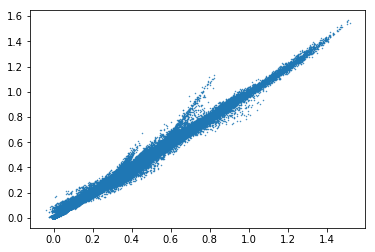

In [15]:
plt.scatter(y_test_pred/df_range['max'][:-1].values, 
            y_test_true/df_range['max'][:-1].values,
            s=0.2)